# Resampling Procedure

- Experiment with Downsampling and Oversampling methods on Random Forest & Gradient Boosting Model (selected due to respectively high preformance compared to other baseline models)
- Combination of Downsampling and Oversampling is used to generate the final resampled dataset for modeling
    - Different Thresholds are tested on RF and GB 

### Prepare and Load Transformed Data 

In [11]:
# import packages
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    confusion_matrix,
    f1_score
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.utils import resample
from collections import Counter
from sklearn.model_selection import GridSearchCV
from itertools import product


In [3]:
# read train and test data in Transformed_Data
X_test = pd.read_csv('../Transformed_Data/X_test.csv')
X_train = pd.read_csv('../Transformed_Data/X_train.csv')
y_test = pd.read_csv('../Transformed_Data/y_test.csv')
y_train = pd.read_csv('../Transformed_Data/y_train.csv')

## Modeling Without Resampling

Baseline Random Forest and Gradient Boosting Results

In [7]:
# model training RF
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train.values.ravel())

# predict the test data
y_pred_rf = rf.predict(X_test)

print('RF Accuracy: ', accuracy_score(y_test, y_pred_rf))
print('RF Precision: ', precision_score(y_test, y_pred_rf))
print('RF Recall: ', recall_score(y_test, y_pred_rf))
print('RF F1 Score: ', f1_score(y_test, y_pred_rf))
print('RF Confusion Matrix: ', confusion_matrix(y_test, y_pred_rf))

RF Accuracy:  0.9917763157894737
RF Precision:  0.9166666666666666
RF Recall:  0.36666666666666664
RF F1 Score:  0.5238095238095238
RF Confusion Matrix:  [[2401    1]
 [  19   11]]


In [8]:
# model training GB
gb = GradientBoostingClassifier(
    n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42
)

# Fit the model to the training data
gb.fit(X_train, y_train)

# Predict the labels for the test set
y_pre_gb = gb.predict(X_test)
y_pred_prob_gb = gb.predict_proba(X_test)[:, 1]

# Print the model's performance
print('GB Accuracy: ', accuracy_score(y_test, y_pre_gb))
print('GB Precision: ', precision_score(y_test, y_pre_gb))
print('GB Recall: ', recall_score(y_test, y_pre_gb))
print('GB F1 Score: ', f1_score(y_test, y_pre_gb))
print('GB Confusion Matrix: ', confusion_matrix(y_test, y_pre_gb))

/Users/kelbell/anaconda/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GB Accuracy:  0.990953947368421
GB Precision:  0.7857142857142857
GB Recall:  0.36666666666666664
GB F1 Score:  0.5
GB Confusion Matrix:  [[2399    3]
 [  19   11]]


## Resampling : Oversample + Downsample

In [13]:
# Separate majority and minority classes
majority_class = X_train[y_train['successful'] == 0]
minority_class = X_train[y_train['successful'] == 1]
majority_labels = y_train[y_train['successful'] == 0]
minority_labels = y_train[y_train['successful'] == 1]

In [21]:
# Grid search for RF on oversample and downsample proportion

# Define the parameter grid
param_grid = {
    'oversample_size': [212, 318, 424, 530, 636],
    'downsample_size': [8000, 7000, 6000, 5000, 4000, 3000, 2000, 1000, 500]
}

# Store results for each parameter combination
results = []
results_gb = []

# Iterate over each combination of oversample and downsample sizes
for oversample_size, downsample_size in product(param_grid['oversample_size'], param_grid['downsample_size']):
    # Upsample the minority class
    minority_upsampled = resample(
        minority_class,
        replace=True,
        n_samples=oversample_size,
        random_state=42
    )
    minority_labels_upsampled = resample(
        minority_labels,
        replace=True,
        n_samples=oversample_size,
        random_state=42
    )

    # Downsample the majority class
    majority_downsampled = resample(
        majority_class,
        replace=False,
        n_samples=downsample_size,
        random_state=42
    )
    majority_labels_downsampled = resample(
        majority_labels,
        replace=False,
        n_samples=downsample_size,
        random_state=42
    )

    # Combine the resampled classes
    X_train_resampled = pd.concat([majority_downsampled, minority_upsampled]).reset_index(drop=True)
    y_train_resampled = pd.concat([majority_labels_downsampled, minority_labels_upsampled]).reset_index(drop=True)

    # Train the model
    rf_model = RandomForestClassifier(random_state=42)
    rf_model.fit(X_train_resampled, y_train_resampled)

    # Predict on the test data
    y_pred = rf_model.predict(X_test)
    y_pred_prob = rf_model.predict_proba(X_test)[:, 1]

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Store the results
    results.append({
        'oversample_size': oversample_size,
        'downsample_size': downsample_size,
        'accuracy': accuracy,
        'f1_score': f1,
        'recall': recall_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred)
    })

    # Train Gradient Boosting Model
    gb_model = GradientBoostingClassifier(
        n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42
    )
    gb_model.fit(X_train_resampled, y_train_resampled)

    # Predict on the test data
    y_pred_gb = gb_model.predict(X_test)
    y_pred_prob_gb = gb_model.predict_proba(X_test)[:, 1]

    # Calculate evaluation metrics
    accuracy_gb = accuracy_score(y_test, y_pred_gb)
    f1_gb = f1_score(y_test, y_pred_gb)
    conf_matrix_gb = confusion_matrix(y_test, y_pred_gb)

    # Store the results
    results_gb.append({
        'oversample_size': oversample_size,
        'downsample_size': downsample_size,
        'accuracy': accuracy_gb,
        'f1_score': f1_gb,
        'recall': recall_score(y_test, y_pred_gb),
        'precision': precision_score(y_test, y_pred_gb)
    })

# Display the results as a DataFrame for easier analysis
results_df = pd.DataFrame(results)
results_df.sort_values(by='recall', ascending=False, inplace=True)  # Sort by best recall
print(results_df)

/Users/kelbell/anaconda/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/kelbell/anaconda/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/kelbell/anaconda/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/kelbell/anaconda/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

    oversample_size  downsample_size  accuracy  f1_score    recall  precision
44              636              500  0.972451  0.361905  0.633333   0.253333
26              424              500  0.970806  0.348624  0.633333   0.240506
43              636             1000  0.986842  0.542857  0.633333   0.475000
35              530              500  0.966694  0.307692  0.600000   0.206897
16              318             1000  0.988076  0.539683  0.566667   0.515152
25              424             1000  0.983141  0.453333  0.566667   0.377778
17              318              500  0.975740  0.365591  0.566667   0.269841
8               212              500  0.977385  0.367816  0.533333   0.280702
34              530             1000  0.984786  0.463768  0.533333   0.410256
23              424             3000  0.993010  0.653061  0.533333   0.842105
40              636             4000  0.992599  0.625000  0.500000   0.833333
7               212             1000  0.989309  0.535714  0.5000

In [25]:
# RF
# Sort by F1 score
results_df = pd.DataFrame(results)
results_df.sort_values(by='f1_score', ascending=False, inplace=True)  # Sort by best f1
print(results_df)

    oversample_size  downsample_size  accuracy  f1_score    recall  precision
31              530             4000  0.993832  0.666667  0.500000   1.000000
23              424             3000  0.993010  0.653061  0.533333   0.842105
14              318             3000  0.993421  0.636364  0.466667   1.000000
40              636             4000  0.992599  0.625000  0.500000   0.833333
32              530             3000  0.992599  0.625000  0.500000   0.833333
41              636             3000  0.992599  0.625000  0.500000   0.833333
19              424             7000  0.993010  0.604651  0.433333   1.000000
13              318             4000  0.993010  0.604651  0.433333   1.000000
28              530             7000  0.993010  0.604651  0.433333   1.000000
39              636             5000  0.992188  0.595745  0.466667   0.823529
18              424             8000  0.992599  0.571429  0.400000   1.000000
27              530             8000  0.992599  0.571429  0.4000

In [22]:
results_gb_df = pd.DataFrame(results_gb)
results_gb_df.sort_values(by='recall', ascending=False, inplace=True)  # Sort by best recall
print(results_gb_df)

    oversample_size  downsample_size  accuracy  f1_score    recall  precision
44              636              500  0.949013  0.279070  0.800000   0.169014
34              530             1000  0.972039  0.392857  0.733333   0.268293
26              424              500  0.952303  0.275000  0.733333   0.169231
35              530              500  0.952303  0.275000  0.733333   0.169231
43              636             1000  0.965049  0.341085  0.733333   0.222222
17              318              500  0.957237  0.287671  0.700000   0.181034
25              424             1000  0.975329  0.400000  0.666667   0.285714
16              318             1000  0.976562  0.412371  0.666667   0.298507
41              636             3000  0.986431  0.535211  0.633333   0.463415
42              636             2000  0.981086  0.452381  0.633333   0.351852
24              424             2000  0.984375  0.500000  0.633333   0.413043
8               212              500  0.968750  0.333333  0.6333

In [26]:
# GB
# Sort by F1 score
results_gb_df = pd.DataFrame(results_gb)
results_gb_df.sort_values(by='f1_score', ascending=False, inplace=True)  # Sort by best f1
print(results_gb_df)

    oversample_size  downsample_size  accuracy  f1_score    recall  precision
27              530             8000  0.993421  0.652174  0.500000   0.937500
38              636             6000  0.992188  0.641509  0.566667   0.739130
29              530             6000  0.991776  0.629630  0.566667   0.708333
13              318             4000  0.992599  0.625000  0.500000   0.833333
28              530             7000  0.992599  0.625000  0.500000   0.833333
18              424             8000  0.993010  0.604651  0.433333   1.000000
36              636             8000  0.991776  0.600000  0.500000   0.750000
31              530             4000  0.990543  0.596491  0.566667   0.629630
30              530             5000  0.990543  0.596491  0.566667   0.629630
37              636             7000  0.990543  0.596491  0.566667   0.629630
2               212             6000  0.992599  0.590909  0.433333   0.928571
21              424             5000  0.991365  0.588235  0.5000

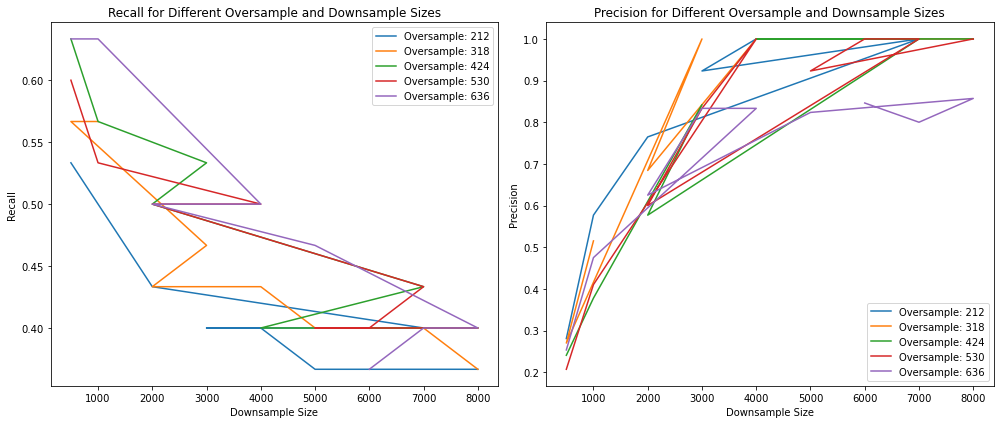

In [23]:
# Ensure columns are converted to numeric arrays
results_df['downsample_size'] = results_df['downsample_size'].astype(int)
results_df['precision'] = results_df['precision'].astype(float)
results_df['recall'] = results_df['recall'].astype(float)

# Plot Precision and Recall for each combination
plt.figure(figsize=(14, 6))

# Plot Recall
plt.subplot(1, 2, 1)
for oversample_size in param_grid['oversample_size']:
    subset = results_df[results_df['oversample_size'] == oversample_size]
    plt.plot(subset['downsample_size'].values, subset['recall'].values, label=f'Oversample: {oversample_size}')
plt.xlabel('Downsample Size')
plt.ylabel('Recall')
plt.title('Recall for Different Oversample and Downsample Sizes')
plt.legend()

# Plot Precision
plt.subplot(1, 2, 2)
for oversample_size in param_grid['oversample_size']:
    subset = results_df[results_df['oversample_size'] == oversample_size]
    plt.plot(subset['downsample_size'].values, subset['precision'].values, label=f'Oversample: {oversample_size}')
plt.xlabel('Downsample Size')
plt.ylabel('Precision')
plt.title('Precision for Different Oversample and Downsample Sizes')
plt.legend()

plt.tight_layout()
plt.show()

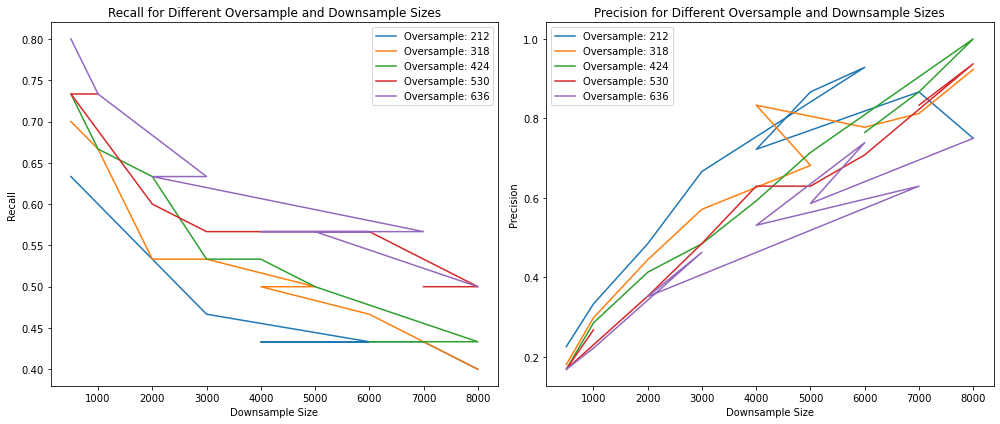

In [24]:
# Ensure columns are converted to numeric arrays
results_gb_df['downsample_size'] = results_gb_df['downsample_size'].astype(int)
results_gb_df['precision'] = results_gb_df['precision'].astype(float)
results_gb_df['recall'] = results_gb_df['recall'].astype(float)

# Plot Precision and Recall for each combination
plt.figure(figsize=(14, 6))

# Plot Recall
plt.subplot(1, 2, 1)
for oversample_size in param_grid['oversample_size']:
    subset = results_gb_df[results_gb_df['oversample_size'] == oversample_size]
    plt.plot(subset['downsample_size'].values, subset['recall'].values, label=f'Oversample: {oversample_size}')
plt.xlabel('Downsample Size')
plt.ylabel('Recall')
plt.title('Recall for Different Oversample and Downsample Sizes')
plt.legend()

# Plot Precision
plt.subplot(1, 2, 2)
for oversample_size in param_grid['oversample_size']:
    subset = results_gb_df[results_gb_df['oversample_size'] == oversample_size]
    plt.plot(subset['downsample_size'].values, subset['precision'].values, label=f'Oversample: {oversample_size}')
plt.xlabel('Downsample Size')
plt.ylabel('Precision')
plt.title('Precision for Different Oversample and Downsample Sizes')
plt.legend()

plt.tight_layout()
plt.show()

## Resampled Data

#### According to best & reasonable recall

In [30]:
# Resample and save data with 1000 size majority and 530 size minority
minority_upsampled = resample(
    minority_class,
    replace=True,
    n_samples=530,
    random_state=42
)
minority_labels_upsampled = resample(
    minority_labels,
    replace=True,
    n_samples=530,
    random_state=42
)

majority_downsampled = resample(
    majority_class,
    replace=False,
    n_samples=1000,
    random_state=42
)
majority_labels_downsampled = resample(
    majority_labels,
    replace=False,
    n_samples=1000,
    random_state=42
)

X_train_resampled = pd.concat([majority_downsampled, minority_upsampled]).reset_index(drop=True)
y_train_resampled = pd.concat([majority_labels_downsampled, minority_labels_upsampled]).reset_index(drop=True)

# Save the resampled data
X_train_resampled.to_csv('../Resample/X_train_resampled_optrecall.csv', index=False)
y_train_resampled.to_csv('../Resample/y_train_resampled_optrecall.csv', index=False)

In [31]:
# print precision, recall, f1 for rf and gb with resampled data
# Train the model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_resampled, y_train_resampled)

# Predict on the test data
y_pred = rf_model.predict(X_test)
y_pred_prob = rf_model.predict_proba(X_test)[:, 1]

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Store the results
print('RF with resampled data')
print('Accuracy: ', accuracy)
print('F1 Score: ', f1)
print('Recall: ', recall_score(y_test, y_pred))
print('Precision: ', precision_score(y_test, y_pred))
print('Confusion Matrix: ', conf_matrix)

# Train Gradient Boosting Model
gb_model = GradientBoostingClassifier(
    n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42
)
gb_model.fit(X_train_resampled, y_train_resampled)

# Predict on the test data
y_pred_gb = gb_model.predict(X_test)
y_pred_prob_gb = gb_model.predict_proba(X_test)[:, 1]

# Calculate evaluation metrics
accuracy_gb = accuracy_score(y_test, y_pred_gb)
f1_gb = f1_score(y_test, y_pred_gb)
conf_matrix_gb = confusion_matrix(y_test, y_pred_gb)

# Store the results
print('GB with resampled data')
print('Accuracy: ', accuracy_gb)
print('F1 Score: ', f1_gb)
print('Recall: ', recall_score(y_test, y_pred_gb))
print('Precision: ', precision_score(y_test, y_pred_gb))
print('Confusion Matrix: ', conf_matrix_gb)

/Users/kelbell/anaconda/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RF with resampled data
Accuracy:  0.9847861842105263
F1 Score:  0.463768115942029
Recall:  0.5333333333333333
Precision:  0.41025641025641024
Confusion Matrix:  [[2379   23]
 [  14   16]]


/Users/kelbell/anaconda/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GB with resampled data
Accuracy:  0.9720394736842105
F1 Score:  0.3928571428571429
Recall:  0.7333333333333333
Precision:  0.2682926829268293
Confusion Matrix:  [[2342   60]
 [   8   22]]


#### According to best & reasonable f1

In [32]:
# Resample and save data with 6000 size majority and 636 size minority
minority_upsampled = resample(
    minority_class,
    replace=True,
    n_samples=636,
    random_state=42
)
minority_labels_upsampled = resample(
    minority_labels,
    replace=True,
    n_samples=636,
    random_state=42
)

majority_downsampled = resample(
    majority_class,
    replace=False,
    n_samples=6000,
    random_state=42
)
majority_labels_downsampled = resample(
    majority_labels,
    replace=False,
    n_samples=6000,
    random_state=42
)

X_train_resampled_f1 = pd.concat([majority_downsampled, minority_upsampled]).reset_index(drop=True)
y_train_resampled_f1 = pd.concat([majority_labels_downsampled, minority_labels_upsampled]).reset_index(drop=True)

# Save the resampled data
X_train_resampled_f1.to_csv('../Resample/X_train_resampled_optf1.csv', index=False)
y_train_resampled_f1.to_csv('../Resample/y_train_resampled_optf1.csv', index=False)

In [33]:
# print precision, recall, f1 for rf and gb with resampled_f1 data
# Train the model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_resampled_f1, y_train_resampled_f1)

# Predict on the test data
y_pred = rf_model.predict(X_test)
y_pred_prob = rf_model.predict_proba(X_test)[:, 1]

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Store the results
print('RF with resampled_f1 data')
print('Accuracy: ', accuracy)
print('F1 Score: ', f1)
print('Recall: ', recall_score(y_test, y_pred))
print('Precision: ', precision_score(y_test, y_pred))
print('Confusion Matrix: ', conf_matrix)

# Train Gradient Boosting Model
gb_model = GradientBoostingClassifier(
    n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42
)
gb_model.fit(X_train_resampled_f1, y_train_resampled_f1)

# Predict on the test data
y_pred_gb = gb_model.predict(X_test)
y_pred_prob_gb = gb_model.predict_proba(X_test)[:, 1]

# Calculate evaluation metrics
accuracy_gb = accuracy_score(y_test, y_pred_gb)
f1_gb = f1_score(y_test, y_pred_gb)
conf_matrix_gb = confusion_matrix(y_test, y_pred_gb)

# Store the results
print('GB with resampled_f1 data')
print('Accuracy: ', accuracy_gb)
print('F1 Score: ', f1_gb)
print('Recall: ', recall_score(y_test, y_pred_gb))
print('Precision: ', precision_score(y_test, y_pred_gb))
print('Confusion Matrix: ', conf_matrix_gb)

/Users/kelbell/anaconda/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RF with resampled_f1 data
Accuracy:  0.9913651315789473
F1 Score:  0.5116279069767441
Recall:  0.36666666666666664
Precision:  0.8461538461538461
Confusion Matrix:  [[2400    2]
 [  19   11]]


/Users/kelbell/anaconda/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GB with resampled_f1 data
Accuracy:  0.9921875
F1 Score:  0.6415094339622641
Recall:  0.5666666666666667
Precision:  0.7391304347826086
Confusion Matrix:  [[2396    6]
 [  13   17]]
